In [1]:
!pip install statsmodels


In [4]:
import pandas as pd

df = pd.read_csv("/content/london_merged.csv")
print(df.columns)


Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


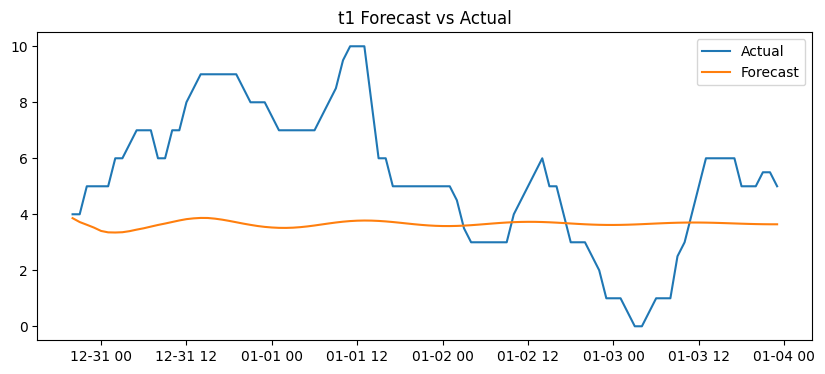

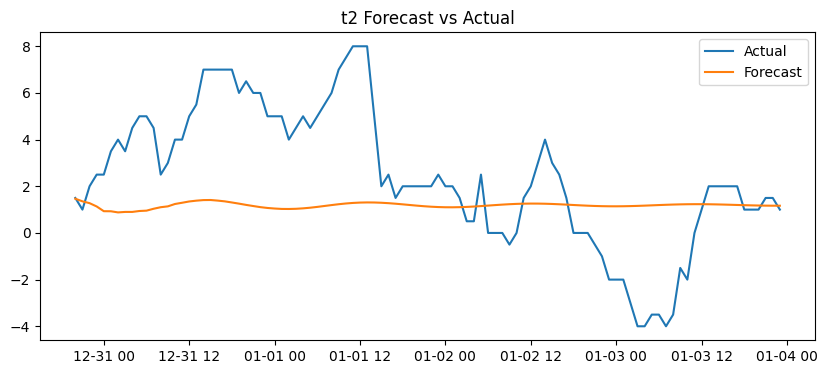

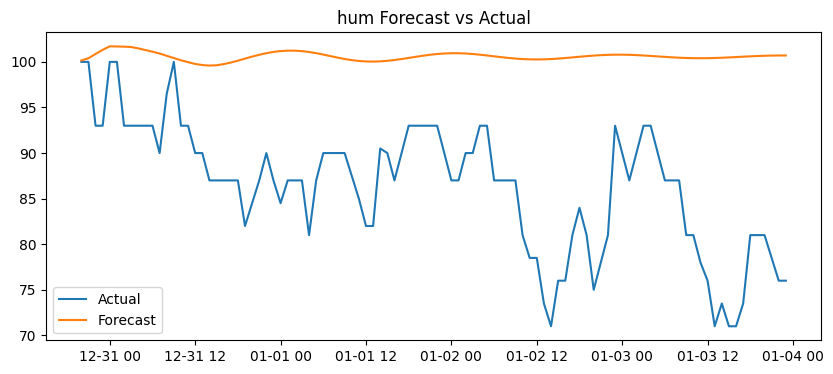

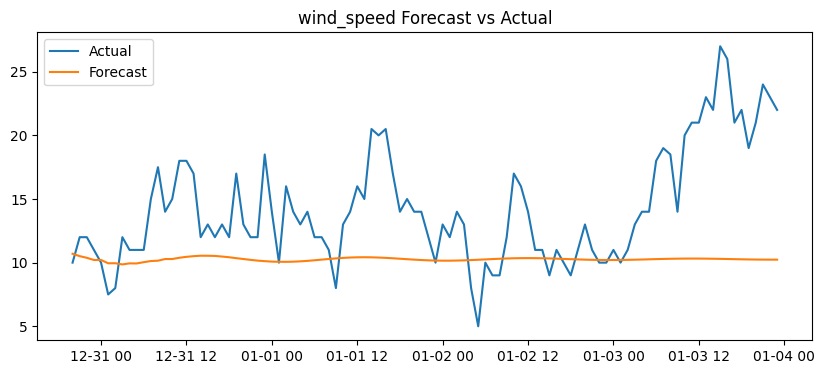

t1 RMSE: 2.9643
t2 RMSE: 3.2093
hum RMSE: 15.7858
wind_speed RMSE: 5.9452


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Load data
df = pd.read_csv("/content/london_merged.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# ✅ Step 2: Use correct column names
df = df[['t1', 't2', 'hum', 'wind_speed']].dropna()

# Step 3: Make the data stationary
diff_df = df.diff().dropna()

# Step 4: Split into train and test
n_obs = 100
train, test = diff_df[:-n_obs], diff_df[-n_obs:]

# Step 5: Fit VAR model
model = VAR(train)
results = model.fit(maxlags=15, ic='aic')

# Step 6: Forecast
forecast = results.forecast(train.values[-results.k_ar:], steps=n_obs)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)

# Step 7: Invert differencing to get actual values
last_train = df.iloc[-n_obs-1:-1]
forecast_values = forecast_df.cumsum() + last_train.values[0]
forecast_values = pd.DataFrame(forecast_values, index=test.index, columns=test.columns)

# Step 8: Plot actual vs forecast
for col in test.columns:
    plt.figure(figsize=(10,4))
    plt.plot(df[col][-n_obs:], label='Actual')
    plt.plot(forecast_values[col], label='Forecast')
    plt.title(f"{col} Forecast vs Actual")
    plt.legend()
    plt.show()

# Step 9: Evaluate
for col in test.columns:
    rmse = np.sqrt(mean_squared_error(df[col][-n_obs:], forecast_values[col]))
    print(f"{col} RMSE: {rmse:.4f}")
